In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:
@tdmclient.notebook.sync_var
def apply_motor_commands(v_r,v_l):
  # Applies the commands v_l and v_r to the Thymio's motors
  # Inputs : v_r (int), v_l (int)
  # Outputs: None

  global motor_left_target, motor_right_target
  motor_left_target = v_l
  motor_right_target = v_r

@tdmclient.notebook.sync_var
def stop_Thymio():
  # Stops the Thymio robot

  global motor_left_target,motor_right_target
  motor_left_target = 0
  motor_right_target = 0

@tdmclient.notebook.sync_var
def get_motor_speeds():
  # Returns the speeds of the motors : motor.left.speed and motor.right.speed variables from the Thymio
  # Outputs : left_motor_speed (int), right_motor_speed (int)

  global motor_left_speed, motor_right_speed
  return motor_right_speed, motor_left_speed

@tdmclient.notebook.sync_var
def get_prox_sensors():
  # Returns the values of the proximity sensors of the Thymio in a list. Indices [0-4] correspond to the front facing ones (indexed from left to right) and [5-6] are the backwards facing sensors
  # Outputs : prox_horizontal (list of ints of length 7)

  global prox_horizontal
  return prox_horizontal

In [13]:
print(get_prox_sensors())
# right2 [0, 0, 0, 3300, 3469, 0, 0]
# left2 [3291, 3278, 0, 0, 0, 0, 0]

[0, 0, 0, 3300, 3469, 0, 0]


In [12]:
stop_Thymio()


In [5]:
def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

print(wrap_to_pi(14.137))

1.570629385640828


In [ ]:
#apply_motor_commands(-10, 10) # turns CW = Right
apply_motor_commands(10, -10) # turns CCW = Left

In [3]:
import warnings
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

from global_variables import *
from computer_vision import *
from kalman import *
from global_navigation import *
from local_navigation import *
from motion_control import *

Mahalanobis distance: 201.229 Y [ 0.55791788 -0.90181065  0.24686815]
Mahalanobis distance: 233.656 Y [ 0.75559242 -0.90618323  0.27086414]
Mahalanobis distance: 218.015 Y [ 0.71075917 -0.8861293   0.26090686]
Mahalanobis distance: 329.773 Y [ 0.89542382 -1.08862205  0.28762046]
Mahalanobis distance: 335.896 Y [ 0.89801407 -1.10137661  0.29836119]
Mahalanobis distance: 509.005 Y [ 1.11693054 -1.36487097  0.30910193]
Mahalanobis distance: 499.256 Y [ 1.11532477 -1.35659736  0.28932936]
Mahalanobis distance: 534.957 Y [ 1.29008237 -1.34743042  0.30365322]
Mahalanobis distance: 542.973 Y [ 1.31407129 -1.36180653  0.3190964 ]
Mahalanobis distance: 564.984 Y [ 1.46713044 -1.33818684  0.33339594]
Mahalanobis distance: 759.378 Y [ 1.68112504 -1.5971466   0.33621324]
Mahalanobis distance: 713.265 Y [ 1.64663234 -1.57019027  0.34175947]
Mahalanobis distance: 793.639 Y [ 1.84375312 -1.63621405  0.36801025]
Mahalanobis distance: 814.523 Y [ 2.0499171  -1.59559576  0.37443011]
Mahalanobis distance

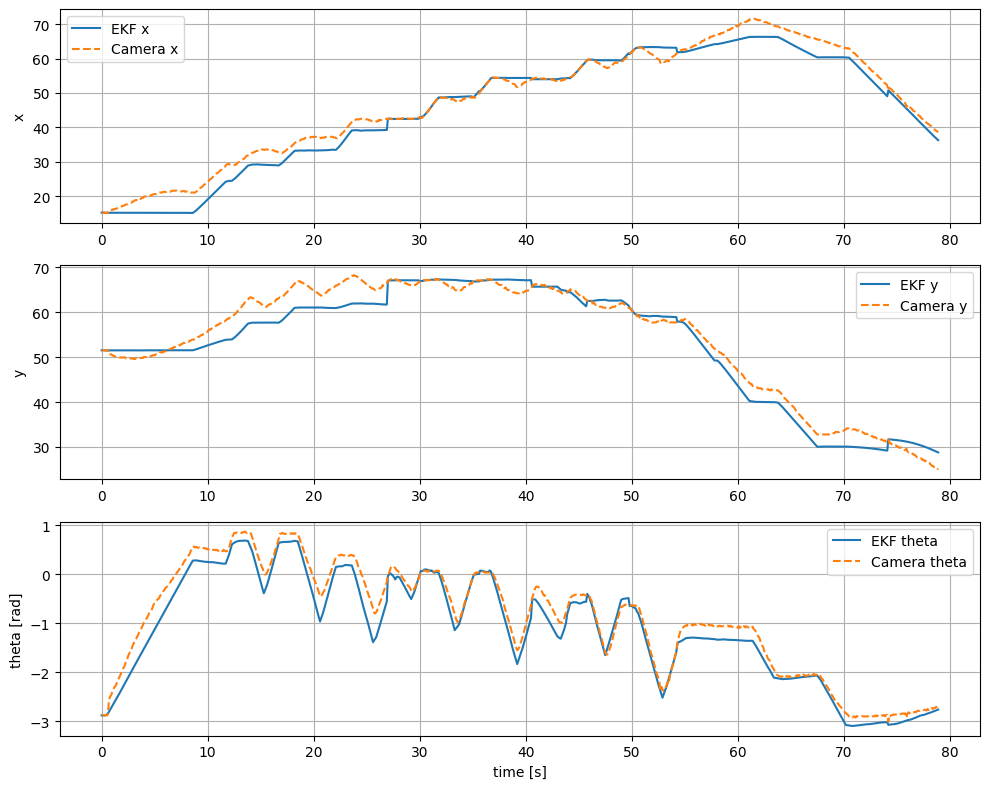

In [5]:
import warnings
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

from global_variables import *
from computer_vision import *
from kalman import *
from global_navigation import *
from local_navigation import *
from motion_control import *

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Could not open webcam")
    exit()

# Global variables
state = "GLOBAL_NAVIGATION"
thymio_start = thymio_theta = goal = polygons = homography = None
theta_des = 0.0
waypoints = None
waypoint_index = 1 # 1 because 0 is the initial position
X_array = [] # vector state logging over time
X_camera_array = [] # vector state from camera logging over time
X = None
P = np.array([[var_x_cam,0,0],[0,var_y_cam,0],[0,0,var_theta_cam]])
prox_values = np.array([0,0,0,0,0,0,0])

local_nav = LocalNav(
    turn_direction="",
    state_local_nav="",
    turn_margin_counter=0,
    turn_counter=0,
    advance_counter=0,
    obstacle_cleared=False,
    realign_done=False,
)


while True:
    current_time = time.time()
    ret, frame = cap.read()
    if not ret:
        print("Frame not received")
        break
        
    prox_values = get_prox_sensors()
    
    if state == "GLOBAL_NAVIGATION":
        thymio_start, thymio_theta, goal, polygons_real_world, homography = get_pose_from_frame(frame, only_thymio=False)
        if thymio_start is None or thymio_theta is None or goal is None:
            cv2.imshow("Feed", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            continue  # wait for a usable frame

        waypoints = get_global_path(thymio_start, goal, polygons_real_world, plot=False)
        if waypoints is None:
            # no path found -> stop and wait
            print("no path")
            apply_motor_commands(0, 0)
            cv2.imshow("Feed", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            continue

        # initialize state X for kalman filter
        X = np.array([thymio_start[0], thymio_start[1], thymio_theta])
        waypoint_index = 1
        state = "ROTATE"

    else:
        # ROTATE / FORWARD: only need Thymio pose (kalman should be here normally)
        thymio_start, thymio_theta = get_pose_from_frame(frame, only_thymio=True)
        if thymio_start is not None and thymio_theta is not None:
            # UPDATE KALMAN FILTER HERE --------------------------------------------------------------------------
            v_r_motor, v_l_motor = get_motor_speeds()
            X, P = update_EKF(thymio_start, thymio_theta, v_r_motor, v_l_motor, X, P, frame)
            #print(f"Kalman pose: x={X[0]:.3f} m, y={X[1]:.3f} m, theta={X[2]:.3f} rad")  # debug

            X_array.append(X.copy()) # copy to avoid corruption
            # Debug: override kalman with camera measurement
            # X[0] = thymio_start[0]
            # X[1] = thymio_start[1]
            # X[2] = thymio_theta
            X_camera_array.append(np.array([thymio_start[0], thymio_start[1], thymio_theta]))


            # CHECK FOR KIDNAPPING HERE --------------------------------------------------------------------------
            if len(X_array) >= 2:
                x_diff = X_array[-1][0] - X_array[-2][0]
                y_diff = X_array[-1][1] - X_array[-2][1]
            else:
                x_diff = 0
                y_diff = 0
            dist_moved = np.linalg.norm([x_diff, y_diff])
            if dist_moved > KIDNAPPING_THRESHOLD:  # threshold for kidnapping detection
                print("Kidnapping detected")
                state = "GLOBAL_NAVIGATION"

    if state == "ROTATE":
        if check_obstacle_trigger(prox_values):
            reset_local_nav(local_nav)
            state = "LOCAL_NAVIGATION"
            
        theta_des = np.arctan2(waypoints[1, waypoint_index]-X[1], waypoints[0, waypoint_index]-X[0])
        delta_theta = (theta_des - X[2] + np.pi) % (2*np.pi) - np.pi

        #print(f"theta_des={theta_des:.3f}, theta={X[2]:.3f}, delta={delta_theta:.3f}") # debug

        if abs(delta_theta) < eps_theta:
            apply_motor_commands(0, 0)
            state = "FORWARD"
        elif delta_theta > 0:
            apply_motor_commands(-ROTATION_SPEED,ROTATION_SPEED)
        else:
            apply_motor_commands(ROTATION_SPEED, -ROTATION_SPEED)

    elif state == "FORWARD":
        if check_obstacle_trigger(prox_values):
            reset_local_nav(local_nav)
            state = "LOCAL_NAVIGATION"
        
        x_diff = waypoints[0,waypoint_index] - X[0]
        y_diff = waypoints[1,waypoint_index] - X[1]
        dist_to_waypoint = np.linalg.norm([x_diff, y_diff])

        #print(f"Distance to waypoint: {dist_to_waypoint:.3f} m") # debug

        if dist_to_waypoint < eps_d:
            apply_motor_commands(0,0)
            waypoint_index += 1
            if waypoint_index >= waypoints.shape[1]:
                break
            state = "ROTATE" # reached waypoint
        else:
            #apply_motor_commands(FORWARD_SPEED, FORWARD_SPEED) # move forward
            v_r, v_l = forward_P_regulator( X, waypoints[:, waypoint_index], FORWARD_SPEED)
            apply_motor_commands(v_r, v_l)

    elif state == "LOCAL_NAVIGATION":
        right_speed,left_speed = local_nav_FSM(local_nav, prox_values)
        print("local nav state:",local_nav.state_local_nav)
        apply_motor_commands(right_speed,left_speed)

        if (local_nav.obstacle_cleared and local_nav.realign_done):
            print("Obstacle cleared and Thymio realigned. Returning to Global.")
            stop_Thymio()
            state = "GLOBAL_NAVIGATION"

    if waypoints is not None and homography is not None:
        draw_global_path(frame, homography, waypoints)
        
    cv2.imshow("Feed", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    elapsed = time.time() - current_time
    if elapsed < dt: 
        time.sleep(dt - elapsed)

print("Thymio reached goal")

cap.release()
cv2.destroyAllWindows()

# PLOTTING THE KALMAN FILTER RESULTS ----------------------------------------

X_np      = np.array(X_array)         # shape (N, 3)
Xcam_np   = np.array(X_camera_array)  # shape (N, 3)
t         = np.arange(len(X_np)) * dt # or np.arange(len(X_np))

plt.figure(figsize=(10, 8))

# x
plt.subplot(3, 1, 1)
plt.plot(t, X_np[:, 0],    label="EKF x")
plt.plot(t, Xcam_np[:, 0], label="Camera x", linestyle="--")
plt.ylabel("x")
plt.legend()
plt.grid(True)

# y
plt.subplot(3, 1, 2)
plt.plot(t, X_np[:, 1],    label="EKF y")
plt.plot(t, Xcam_np[:, 1], label="Camera y", linestyle="--")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# theta
plt.subplot(3, 1, 3)
plt.plot(t, X_np[:, 2],    label="EKF theta")
plt.plot(t, Xcam_np[:, 2], label="Camera theta", linestyle="--")
plt.xlabel("time [s]")
plt.ylabel("theta [rad]")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
stop_Thymio()